In [1]:
# module
import os
import matplotlib.pylab as pl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import datetime
import cv2
import numpy as np
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dataset_invariance
import index_qualitative
from torch.autograd import Variable
import csv
import time
import tqdm
import torch.nn.functional as F

# Scene colormap 
colors = [(0, 0, 0), (0.87, 0.87, 0.87), (0.54, 0.54, 0.54), (0.49, 0.33, 0.16), (0.29, 0.57, 0.25)]
cmap_name = 'scene_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=5)

In [2]:
# function
def draw_track_autoencoder(past, future, pred=None, video_id='', vec_id='', index_tracklet=0):

    fig = plt.figure()
    plt.plot(past[:, 0], past[:, 1], c='blue', linewidth=1, marker='o', markersize=1)
    plt.plot(future[:, 0], future[:, 1], c='green', linewidth=1, marker='o', markersize=1)
    if pred is not None:
        plt.plot(pred[:, 0], pred[:, 1], c='red', linewidth=1, marker='o', markersize=1)
    plt.axis('equal')
    plt.title(video_id + '_' + vec_id + '_' + str(index_tracklet).zfill(3))
    plt.show()
    plt.close(fig)

def draw_predictions(past, future, scene_track, pred=None, angle=0, video_id='', vec_id='', index_tracklet=0,
                horizon_dist=None):
    """
    Plot past and future trajectory and save it to test folder.
    :param past: the observed trajectory
    :param future: ground truth future trajectory
    :param pred: predicted future trajectory
    :param angle: rotation angle to plot the trajectory in the original direction
    :param video_id: video index of the trajectory
    :param vec_id: vehicle type of the trajectory
    :param pred: predicted future trajectory
    :param: the observed scene where is the trajectory
    :param index_tracklet: index of the trajectory in the dataset (default 0)
    :param num_epoch: current epoch (default 0)
    :return: None
    """

    colors = [(0, 0, 0), (0.87, 0.87, 0.87), (0.54, 0.54, 0.54), (0.49, 0.33, 0.16), (0.29, 0.57, 0.25)]
    cmap_name = 'scene_cmap'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=5)
    fig = plt.figure()
    plt.imshow(scene_track, cmap=cm)
    colors = pl.cm.Reds(np.linspace(1, 0.3, pred.shape[0]))

    matRot_track = cv2.getRotationMatrix2D((0, 0), -angle, 1)
    past = cv2.transform(past.numpy().reshape(-1, 1, 2), matRot_track).squeeze()
    future = cv2.transform(future.numpy().reshape(-1, 1, 2), matRot_track).squeeze()
    story_scene = past * 2 + dim_clip
    future_scene = future * 2 + dim_clip
    plt.plot(story_scene[:, 0], story_scene[:, 1], c='blue', linewidth=1, marker='o', markersize=1)
    if pred is not None:
        for i_p in reversed(range(pred.shape[0])):
            pred_i = cv2.transform(pred[i_p].numpy().reshape(-1, 1, 2), matRot_track).squeeze()
            pred_scene = pred_i * 2 + dim_clip
            plt.plot(pred_scene[:, 0], pred_scene[:, 1], color=colors[i_p], linewidth=0.5, marker='o', markersize=0.5)
    plt.plot(future_scene[:, 0], future_scene[:, 1], c='green', linewidth=1, marker='o', markersize=1)
    plt.title('FDE 1s: ' + str(horizon_dist[0]) + ' FDE 2s: ' + str(horizon_dist[1]) + ' FDE 3s: ' +
              str(horizon_dist[2]) + ' FDE 4s: ' + str(horizon_dist[3]))
    plt.axis('equal')
    plt.show()
    plt.close(fig)

In [3]:
# Parameters
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
batch_size = 256
past_len = 20
future_len = 40
dim_embedding_key = 48
num_prediction = 5
dim_clip = 180
#注意cpu
# Model
mem_n2n = torch.load('pretrained_models/MANTRA/model_MANTRA',  map_location=torch.device('cpu')).eval()

/home/zbh/miniconda3/envs/MANTRA/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'models.model_memory_IRM.model_memory_IRM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/zbh/miniconda3/envs/MANTRA/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.distance.CosineSimilarity' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/zbh/miniconda3/envs/MANTRA/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retri

In [4]:
mem_n2n

model_memory_IRM(
  (similarity): CosineSimilarity()
  (conv_past): Conv1d(2, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv_fut): Conv1d(2, 16, kernel_size=(1,), stride=(1,), padding=(1,))
  (encoder_past): GRU(16, 48, batch_first=True)
  (encoder_fut): GRU(16, 48, batch_first=True)
  (decoder): GRU(96, 96)
  (FC_output): Linear(in_features=96, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_controller): Linear(in_features=1, out_features=1, bias=True)
  (convScene_1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convScene_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_runn

In [5]:
# Dataset
tracks = json.load(open('kitti_dataset.json'))
print('creating dataset...')
data_train = dataset_invariance.TrackDataset(tracks, len_past=past_len, len_future=future_len,
                                             train=True, dim_clip=dim_clip)
data_test = dataset_invariance.TrackDataset(tracks, len_past=past_len, len_future=future_len,
                                     train=False, dim_clip=dim_clip)
train_loader = DataLoader(data_train, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, num_workers=1, shuffle=False)
print('dataset created')

# loader iterator (test)
dataiter_test = iter(test_loader)

creating dataset...
video: 0005
video: 0009


/home/zbh/code/MANTRA-CVPR20/dataset_invariance.py:191: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)


video: 0011
video: 0013
video: 0014
video: 0017
video: 0027
video: 0028
video: 0048
video: 0051
video: 0056
video: 0057
video: 0059
video: 0060
video: 0084
video: 0091
video: 0001
video: 0002
video: 0015
video: 0018
video: 0029
video: 0032
video: 0052
video: 0070
dataset created


In [6]:
# iteration (test)
(index, past, future, presents, angle_presents, videos, vehicles, number_vec, scene, scene_one_hot) = dataiter_test.next()

In [40]:
# past: [batch size, observation length,2]
# future: [batch size, prediction length,2]
# scene is for qualitative evaluation, scene_one_hot is for IRM

# AUTOENCODER AND ABLATION STUDY (IMPORTANCE OF PAST)

In [7]:
# Model Inference
# if ablation_study is None, the inference is default.
# if 'zeros', encoding of past is all zeros.
# if 'rand', encoding of past is random numbers (standard normal distribution, mean 0, variance 1).
# if 'different', encoding of all pasts (of batch) is the encoding of 'j_ablation' past.
ablation_study = None
j_ablation = 802

with torch.no_grad():
    dim_batch = past.size()[0]
    zero_padding = torch.zeros(1, dim_batch, mem_n2n.dim_embedding_key * 2)
    reconstruction = torch.Tensor()
    present = past[:, -1, :2].unsqueeze(1) #最近一个时刻观察到的位置

    # temporal encoding for past
    past_t = torch.transpose(past, 1, 2)
    past_embed = mem_n2n.relu(mem_n2n.conv_past(past_t))
    past_embed = torch.transpose(past_embed, 1, 2)

    # temporal encoding for future
    future_t = torch.transpose(future, 1, 2)
    future_embed = mem_n2n.relu(mem_n2n.conv_fut(future_t))
    future_embed = torch.transpose(future_embed, 1, 2)

    # sequence encoding
    output_past, state_past = mem_n2n.encoder_past(past_embed)
    output_fut, state_fut = mem_n2n.encoder_fut(future_embed)

    if ablation_study is not None:
        if ablation_study is 'zeros':
            state_past = torch.zeros([1, dim_batch, 48])
        elif ablation_study is 'rand':
            state_past = torch.randn([1, dim_batch, 48])
        elif ablation_study is 'different':
            state_past = state_past[:,j_ablation].unsqueeze(0).repeat(1, dim_batch,1)

    # concatenate
    state_conc = torch.cat((state_past, state_fut), 2)
    input_fut = state_conc
    state_fut = zero_padding
    for i_pred in range(mem_n2n.future_len):
        output_decoder, state_fut = mem_n2n.decoder(input_fut, state_fut)
        displacement_next = mem_n2n.FC_output(output_decoder)
        coords_next = present + displacement_next.squeeze(0).unsqueeze(1)
        reconstruction = torch.cat((reconstruction, coords_next), 1)
        present = coords_next
        input_fut = zero_padding
    reconstruction = reconstruction.numpy()

In [33]:
state_past.size()

torch.Size([1, 1280, 48])

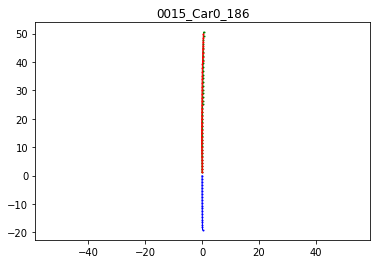

In [21]:
t = 232
draw_track_autoencoder(past[t], future[t], reconstruction[t], video_id=videos[t], vec_id=vehicles[t] + number_vec[t], index_tracklet=index[t].item() )

# EXAMPLE OF PREDICTION USING MANTRA

In [42]:
# MANTRA INFERENCE

scene_mantra = scene_one_hot.clone()
with torch.no_grad():
    dim_batch = past.size()[0]
    zero_padding = torch.zeros(1, dim_batch * num_prediction, mem_n2n.dim_embedding_key * 2)
    prediction_mantra = torch.Tensor()
    present = past[:, -1].unsqueeze(1)
    #checking the inference time
    start = time.time()
    # past temporal encoding
    past_t = torch.transpose(past, 1, 2)
    story_embed = mem_n2n.relu(mem_n2n.conv_past(past_t))
    story_embed = torch.transpose(story_embed, 1, 2)
    output_past, state_past = mem_n2n.encoder_past(story_embed)

    # Cosine similarity and memory read
    past_normalized = F.normalize(mem_n2n.memory_past, p=2, dim=1)
    state_normalized = F.normalize(state_past.squeeze(dim=0), p=2, dim=1)
    weight_read = torch.matmul(past_normalized, state_normalized.transpose(0, 1)).transpose(0, 1)
    index_max = torch.sort(weight_read, descending=True)[1].cpu()[:, :num_prediction]
    present = present.repeat_interleave(num_prediction, dim=0)
    state_past = state_past.repeat_interleave(num_prediction, dim=1)
    ind = index_max.flatten()

    info_future = mem_n2n.memory_fut[ind]
    info_total = torch.cat((state_past, info_future.unsqueeze(0)), 2)
    input_dec = info_total
    state_dec = zero_padding
    for i in range(future_len):
        output_decoder, state_dec = mem_n2n.decoder(input_dec, state_dec)
        displacement_next = mem_n2n.FC_output(output_decoder)
        coords_next = present + displacement_next.squeeze(0).unsqueeze(1)
        prediction_mantra = torch.cat((prediction_mantra, coords_next), 1)
        present = coords_next
        input_dec = zero_padding
    
    scene_mantra = scene_mantra.permute(0, 3, 1, 2)
    scene_1 = mem_n2n.convScene_1(scene_mantra)
    scene_2 = mem_n2n.convScene_2(scene_1)
    scene_2 = scene_2.repeat_interleave(num_prediction, dim=0)

    # Iteratively refine predictions using context
    for i_refine in range(4):
        pred_map = prediction_mantra + 90
        pred_map = pred_map.unsqueeze(2)
        indices = pred_map.permute(0, 2, 1, 3)
        # rescale between -1 and 1
        indices = 2 * (indices / 180) - 1
        output = F.grid_sample(scene_2, indices, mode='nearest')
        output = output.squeeze(2).permute(0, 2, 1)

        state_rnn = state_past
        output_rnn, state_rnn = mem_n2n.RNN_scene(output, state_rnn)
        prediction_refine = mem_n2n.fc_refine(state_rnn).view(-1, future_len, 2)
        prediction_mantra = prediction_mantra + prediction_refine
    print(time.time()-start)
    prediction_mantra = prediction_mantra.view(dim_batch, num_prediction, future_len, 2)

future_rep = future.unsqueeze(1).repeat(1, num_prediction, 1, 1)
distances = torch.norm(prediction_mantra - future_rep, dim=3)#预测和真实值之间的距离
mean_distances = torch.mean(distances, dim=2)
index_min = torch.argmin(mean_distances, dim=1)
distance_pred = distances[torch.arange(0, len(index_min)), index_min]#误差最小的那一组距离

2.5315024852752686


In [37]:
distances.shape

torch.Size([256, 5, 40])

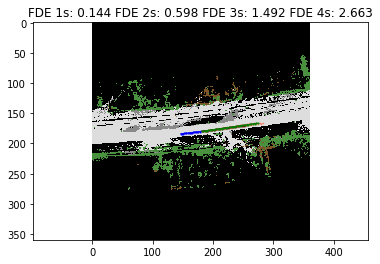

In [26]:
t = 222
horizon_dist = [round(distance_pred[t, 9].item(), 3), round(distance_pred[t, 19].item(), 3),
                round(distance_pred[t, 29].item(), 3), round(distance_pred[t, 39].item(), 3)]
draw_predictions(past[t], future[t], scene[t], prediction_mantra[t], angle_presents[t], videos[t], vehicles[t] + number_vec[t],
                                            index_tracklet=index[t], horizon_dist=horizon_dist)